In [38]:
import fastf1 as ff1
from fastf1 import plotting

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

import numpy as np

In [39]:
# Enable the cache
ff1.Cache.enable_cache('cache') 

# Get rid of an error
pd.options.mode.chained_assignment = None

In [40]:
# Load the session data
session = ff1.get_session(2022, 'Barcelona', 'FP2')

# Get the laps
laps = session.load_laps()

C:\Users\trym1\anaconda3\lib\site-packages\fastf1\core.py:1116: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Spanish Grand Prix - Practice 2 [v2.2.6]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '47', '44', '31', '24', '23', '22', '20', '18',

In [41]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [42]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.65), laps['LapTimeSeconds'].quantile(0.35)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [43]:
drivers_to_visualize = ['VER', 'PER', 'LEC', 'SAI', 'VET']

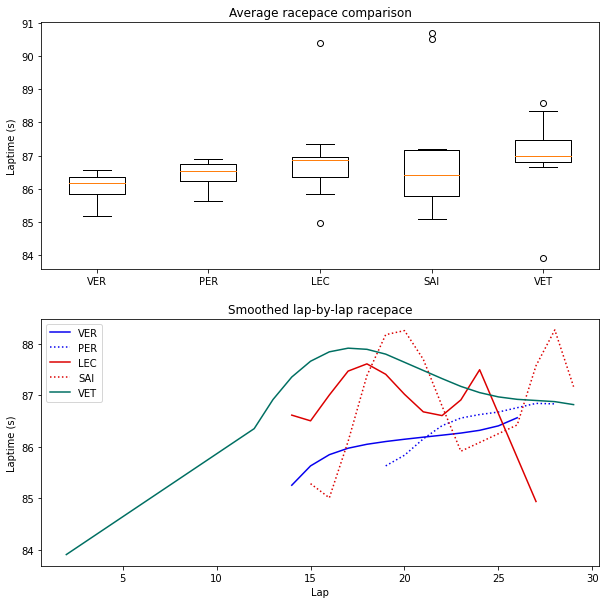

In [44]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 10]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)


##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')



##############################
#
# Lap-by-lap racepace comparison
#
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # Generate legend
    ax[1].legend()
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)
    
    plt.savefig('racepace_comparison.png', dpi=300)

In [45]:
laps[['Driver', 'SpeedST']].groupby(['Driver']).max().sort_values('SpeedST', ascending=False)

,SpeedST
Driver,
TSU,324.0
LAT,322.0
PER,322.0
ALB,321.0
VER,321.0
RUS,319.0
MSC,319.0
GAS,318.0
HAM,318.0
